In [3]:
# !pip install keras
!pip install tensorflow

^C


     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.5 kB ? eta -:--:--
     -------------------------------------- 57.5/57.5 kB 761.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     --------------- ------------------------ 0.6/1.5 MB 12.4 MB/s eta 0:00:01
     --------------------------------- ------ 1.2/1.5 MB 13.2 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 10.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/284.1 MB ? eta -:--:--
   ---------------------------------------- 0.6/284.1 MB 18.8 MB/s eta 0:00:16
   ---------

In [69]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
import csv
from keras.layers import Conv2D,MaxPool2D,Flatten,LSTM,Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from keras.callbacks import ModelCheckpoint

In [32]:
file_dir = r"C:\Users\Saad KOUKOUS\Documents\Projet5A\DCASE_2023_Challenge_Task_7_Dataset\clean_dev\\"

In [33]:
def build_rand_feat():
    X = []
    y = []
    _min , _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=probabilties)
        file = np.random.choice(df[df.label==rand_class].index)
        rate,wav = wavfile.read(file_dir+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt=config.nfilt,nfft=config.nfft)
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    X,y = np.array(X),np.array(y)
    X = (X - _min)/(_max - _min)
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    y = to_categorical(y,num_classes=7)
    return X,y
    

In [58]:
def conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [55]:
class Config:
    def __init__(self,nfilt=26,nfeat=13,nfft=512,rate=16000):
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step=int(rate/2)
        self.model_path = os.path.join('models','.model')
        self.p_path = os.path.join('pickles','.p')
    

In [47]:
df = pd.read_csv('data_labeled.csv')
df.set_index('fname',inplace =True)

In [48]:
for f in df.index:
    rate,signal = wavfile.read(file_dir+f)
    df.at[f,'length'] = signal.shape[0]/rate

In [49]:
df = df[df['length'] > 0.5]

In [50]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
class_dist

label
dog_bark                2.919940
footstep                3.460266
gunshot                 3.086763
keyboard                3.680230
moving_motor_vehicle    3.969351
rain                    3.933350
sneeze_cough            2.268705
Name: length, dtype: float64

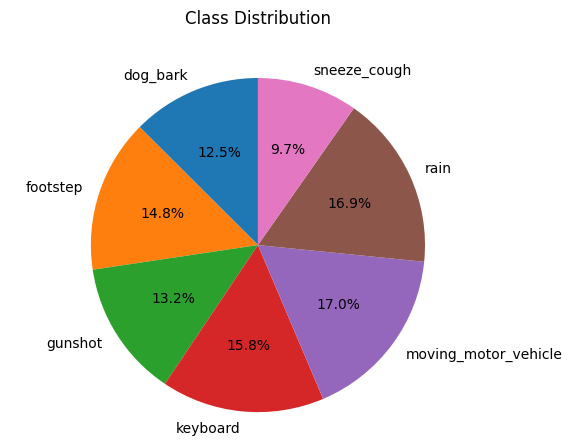

In [51]:
fig,ax = plt.subplots()
ax.set_title('Class Distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()

In [52]:
n_samples = 2*int(df['length'].sum()/0.5)
probabilties = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index,p=probabilties)
n_samples,probabilties,choices

(63798,
 label
 dog_bark                0.125219
 footstep                0.148391
 gunshot                 0.132373
 keyboard                0.157824
 moving_motor_vehicle    0.170222
 rain                    0.168679
 sneeze_cough            0.097292
 Name: length, dtype: float64,
 'footstep')

In [53]:
config = Config()

In [57]:
X,y = build_rand_feat()


100%|██████████| 63798/63798 [06:09<00:00, 172.77it/s]


In [68]:
y_flat = np.argmax(y,axis=1)
input_shape = (X.shape[1],X.shape[2],1)
model = conv_model()
class_weight = compute_class_weight(class_weight = "balanced", classes = np.unique(y_flat), y = y_flat)
class_weights = dict(zip(np.unique(y_flat), class_weight))
checkpoint = ModelCheckpoint('models.model',monitor='val_acc',verbose=1,mode='max',save_best_only=True,save_weights_only=False,period=1)
model.fit(X,y,epochs=10, batch_size=32,shuffle=True,class_weight=class_weights,validation_split=0.1,callbacks=[checkpoint])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 9, 13, 16)         160       
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 13, 32)         4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 4, 6, 128)         0         
                                                      

In [70]:
model.save('model.model')

INFO:tensorflow:Assets written to: model.model\assets


INFO:tensorflow:Assets written to: model.model\assets
